<a href="https://colab.research.google.com/github/namespaiva/pred-analysis/blob/main/simulado1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulado

## 1

In [133]:
!pip install ucimlrepo

In [74]:
import ucimlrepo
import pandas as pd
import seaborn as sns
import arviz as az
import pymc as pm
import matplotlib.pyplot as plt
import numpy as np

dados = ucimlrepo.fetch_ucirepo(id=53)

X = dados.data.features
y= dados.data.targets

filtro = y['class'] != 'Iris-virginica'
y = y[filtro]
X = X[filtro]

y = y.replace('Iris-setosa', 0)
y = y.replace('Iris-versicolor', 1)

X_f = X.copy()
y_f = y.copy()

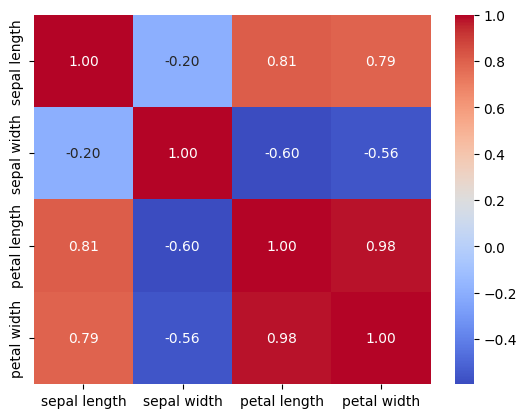

In [75]:
from sklearn.model_selection import train_test_split as tts

X_train, X_test, y_train, y_test = tts(X_f, y_f, test_size=0.2)

sns.heatmap(X_f.corr(), annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.show()

In [76]:
cols = list(X.columns)

coords = {'features': cols}

In [77]:
import pytensor.tensor as tt

with pm.Model(coords = coords) as modeloIris:
  betas = pm.Normal('betas', 0, 1, dims='features')
  alpha = pm.Normal('alpha')

  X = [
    pm.MutableData("X_"+column,X_train[column].values)
    for column in X_train.columns if np.issubdtype(X_f[column].dtype, np.number)
  ]

  y = pm.MutableData("y",y_train.values.flatten())

  mu = alpha + tt.dot(betas, X)
  likelihood = pm.Bernoulli('likelihood',pm.math.invlogit(mu),observed=y)

with modeloIris:
  trace_prior = pm.sample_prior_predictive()

/usr/local/lib/python3.10/dist-packages/pymc/data.py:304: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


In [78]:
trace_prior

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data
	> constant_data

In [79]:
prior_samples = trace_prior['prior_predictive']['likelihood']

prior_samples_flat = prior_samples.values.flatten()

unique_values = np.unique(y_train)

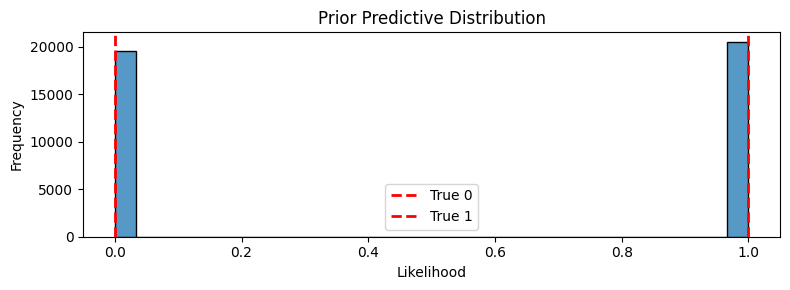

In [80]:
fig, ax = plt.subplots(figsize=(8, 3))

sns.histplot(data=prior_samples_flat, bins=30, kde=False, ax=ax)

for value in unique_values:
    ax.axvline(value, color='r', linestyle='--', linewidth=2, label=f'True {value}')

ax.set_title("Prior Predictive Distribution")
ax.set_xlabel("Likelihood")
ax.set_ylabel("Frequency")

ax.legend()

plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


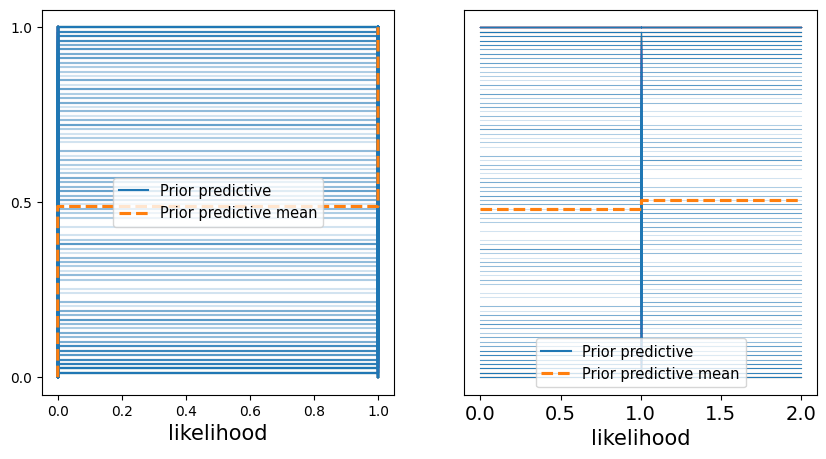

In [81]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

az.plot_ppc(trace_prior, group='prior', kind='cumulative',ax=axes[0]);
az.plot_ppc(trace_prior, group='prior',ax=axes[1]);

In [82]:
with modeloIris:
  #approx = pm.fit(2000)
  trace = pm.sample(20000)

Output()

Output()

ERROR:pymc.stats.convergence:There were 7 divergences after tuning. Increase `target_accept` or reparameterize.


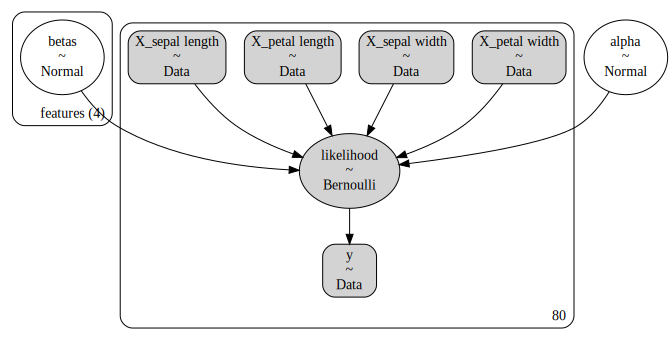

In [83]:
pm.model_to_graphviz(modeloIris)

In [84]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.285,0.969,-2.116,1.535,0.007,0.005,21977.0,21108.0,1.0
betas[sepal length],-0.462,0.593,-1.593,0.628,0.005,0.003,15934.0,18310.0,1.0
betas[sepal width],-1.466,0.763,-2.880,-0.034,0.006,0.004,18582.0,20506.0,1.0
betas[petal length],2.352,0.625,1.190,3.537,0.005,0.003,16745.0,17589.0,1.0
betas[petal width],1.036,0.939,-0.725,2.805,0.006,0.005,21269.0,22584.0,1.0


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'betas'}>,
        <Axes: title={'center': 'betas'}>]], dtype=object)

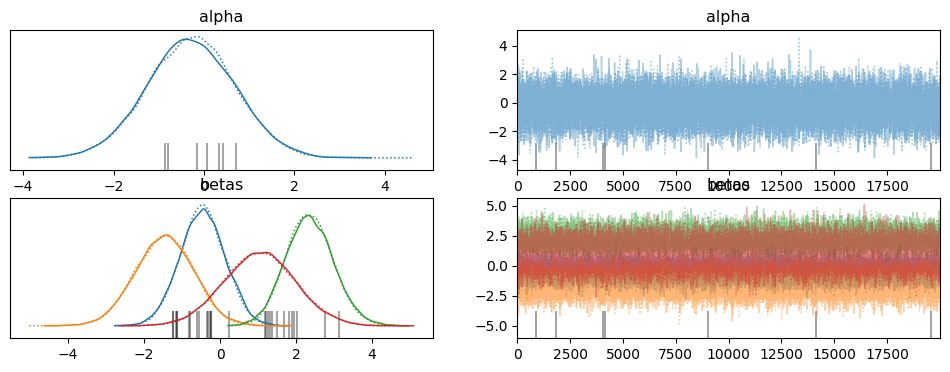

In [85]:
az.plot_trace(trace)

In [86]:
vars = {"X_"+column : X_test[column].values
    for column in X_test.columns if np.issubdtype(X_test[column].dtype, np.number)}
vars["y"] = y_test.values.flatten()

with modeloIris:
  pm.set_data(vars)
  trace_post = pm.sample_posterior_predictive(trace)

Output()

In [89]:
mean_likelihood = trace_post.posterior_predictive.likelihood.mean(dim=['chain', 'draw'])
binary_predictions = (mean_likelihood > 0.5).astype(int).values[:len(y_test.values.flatten())]

abs_diff = np.abs(y_test.values.flatten() - binary_predictions)
accuracy = 1 - np.mean(abs_diff)

df = pd.DataFrame({'y_test': y_test.values.flatten(), 'binary_predictions': binary_predictions})
df['abs_diff'] = abs_diff
df['accuracy'] = accuracy

errors = df["abs_diff"].sum()
acc = (len(df)-errors)/len(df)
print(f"Acuracia: {acc:.4f}")
print(f"Erros: {errors}")

Acuracia: 1.0000
Erros: 0


## 2

In [141]:
!pip install ucimlrepo

In [142]:
import ucimlrepo
import pandas as pd
import seaborn as sns
import arviz as az
import pymc as pm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
import pytensor.tensor as tt
dados = ucimlrepo.fetch_ucirepo(id=162)

df = pd.DataFrame(dados.data.features)
df['areas'] = dados.data.targets

months = {'jan':1, 'feb':2, 'mar':3, 'apr':4, 'may':5, 'jun':6, 'jul':7, 'aug':8, 'sep':9, 'oct':10, 'nov':11, 'dec':12}
days = {'mon':1, 'tue':2, 'wed':3, 'thu':4, 'fri':5, 'sat':6, 'sun':0}

df['month'] = df['month'].map(months)
df['day'] = df['day'].map(days)

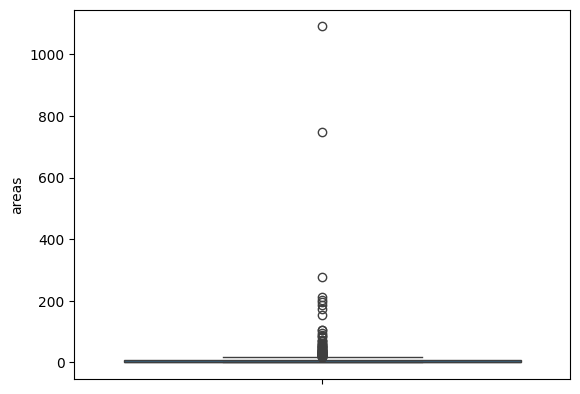

In [143]:
sns.boxplot(df['areas'])
plt.show()

In [144]:
# Remover outliers?
df = df[df['areas'] < 400]
features = df[['X', 'Y', 'temp']]
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

from sklearn.cluster import KMeans

n_clusters = 5

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(features_scaled)

df['cluster'] = clusters

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
<ipython-input-144-1bb5578215ff>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster'] = clusters


In [145]:
from sklearn.model_selection import train_test_split as tts

# coords = {
#     'features': ['month', 'day', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH',
#        'wind', 'rain', 'cluster']
# }

X = pd.DataFrame()
y = pd.DataFrame()

X = df.drop(['areas','X','Y'], axis=1)
y = df['areas']

coords = {
    'features': X.columns
}

scaler = StandardScaler()
X_f = X.copy()
X_f = scaler.fit_transform(X)
X_f = pd.DataFrame(X_f, columns=X.columns)

X_train, X_test, y_train, y_test = tts(X_f, y, test_size=0.3)

In [146]:
def analise_priori(trace):
  fig, axes = plt.subplots(3, 2, figsize=(10,10), gridspec_kw={'hspace': 0.4, 'wspace': 0.3})

  sns.histplot(trace.prior['betas'].values.flatten(), bins=20, kde=True, ax=axes[0][0], )
  axes[0][0].set_xlabel("Betas")
  axes[0][0].set_ylabel("Contagem")
  sns.histplot(trace.prior_predictive['Y_obs'].values.flatten(), bins=20, kde=True, ax=axes[0][1])
  axes[0][1].set_xlabel("Y_obs")
  axes[0][1].set_ylabel("Contagem")

  prior_samples = trace['prior_predictive']['Y_obs']

  # As samples precisam ter o mesmo shape
  prior_samples_reshaped = prior_samples.values.reshape(len(y), -1)

  mean_pred = np.mean(prior_samples_reshaped, axis=1)
  std_pred = np.std(prior_samples_reshaped, axis=1)

  sns.lineplot(data={'x': range(len(y)), 'y': mean_pred}, palette='viridis', ax=axes[1][0])
  sns.kdeplot(data={'x': range(len(y)), 'y': mean_pred}, fill=True, alpha=0.3, ax=axes[1][0])

  for i in range(len(y)):
      axes[1][0].fill_between(range(len(y)), mean_pred[i] - std_pred[i], mean_pred[i] + std_pred[i], alpha=0.2)

  axes[1][0].set_title("Predict a Priori")
  axes[1][0].set_xlabel("Observado")
  axes[1][0].set_ylabel("Predicted")

  axes[1][0].legend(['Predicted'])

  # Removed the axes assignment. The az.plot_ppc function will return an Axes object, but we don't need to assign it to a variable.
  az.plot_ppc(ridge_trace_prior, group='prior', kind='cumulative',ax=axes[2][0], observed=True);
  az.plot_ppc(ridge_trace_prior, group='prior',ax=axes[2][1], observed=True);

  return fig, axes

def analise_posteriori(trace):
  fig, axes = plt.subplots(1, 2, figsize=(10, 5))
  az.plot_ppc(trace, group='posterior', kind='cumulative', ax=axes[0]);
  az.plot_ppc(trace, group='posterior',ax=axes[1]);

  return fig, axes

In [147]:
with pm.Model(coords=coords) as model_ridge:
  alpha = pm.Normal('alpha', 0, 1)
  betas = pm.Normal('betas', 0, 1, dims='features')
  epsilon = pm.HalfNormal('epsilon', 1)

  mu = alpha + tt.dot(X_f, betas)

  likelihood = pm.Normal('Y_obs', mu, epsilon, observed=y)
  ridge_trace_prior = pm.sample_prior_predictive()
  trace_ridge = pm.sample(1000)

Output()

Output()

(<Figure size 1000x1000 with 6 Axes>,
 array([[<Axes: xlabel='Betas', ylabel='Contagem'>,
         <Axes: xlabel='Y_obs', ylabel='Contagem'>],
        [<Axes: title={'center': 'Predict a Priori'}, xlabel='Observado', ylabel='Predicted'>,
         <Axes: >],
        [<Axes: xlabel='Y_obs'>, <Axes: xlabel='Y_obs'>]], dtype=object))

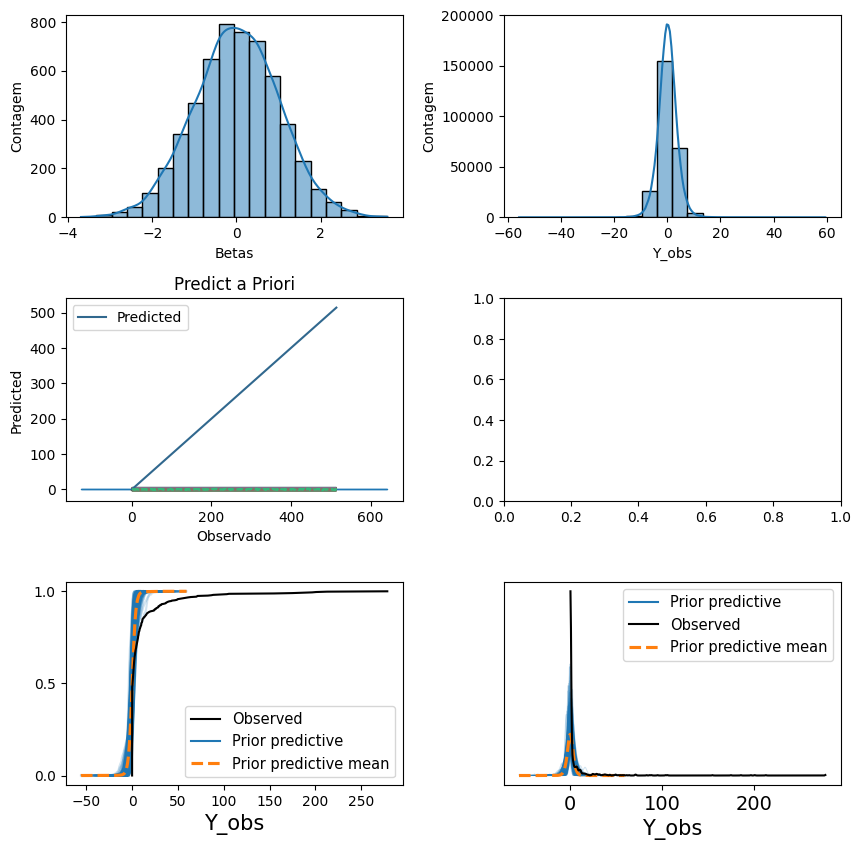

In [148]:
analise_priori(ridge_trace_prior)

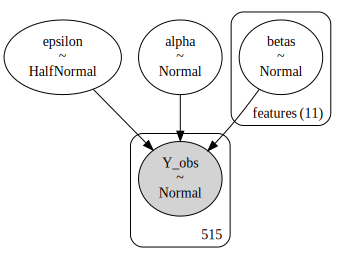

In [149]:
pm.model_to_graphviz(model_ridge)

In [150]:
pm.summary(trace_ridge)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,5.144,0.687,3.867,6.432,0.011,0.008,3755.0,1513.0,1.0
betas[month],0.768,0.744,-0.564,2.202,0.014,0.012,3064.0,1544.0,1.0
betas[day],-0.327,0.633,-1.472,0.933,0.010,0.012,3816.0,1423.0,1.0
betas[FFMC],0.190,0.729,-1.197,1.611,0.012,0.016,3730.0,1705.0,1.0
betas[DMC],0.814,0.739,-0.530,2.164,0.012,0.012,3980.0,1530.0,1.0
betas[DC],-0.101,0.808,-1.651,1.426,0.014,0.017,3242.0,1523.0,1.0
betas[ISI],-0.916,0.715,-2.190,0.488,0.012,0.010,3652.0,1714.0,1.0
betas[temp],0.752,0.760,-0.707,2.103,0.012,0.011,3753.0,1871.0,1.0
betas[RH],-0.430,0.720,-1.724,0.925,0.012,0.012,3462.0,1801.0,1.0
betas[wind],0.302,0.666,-0.959,1.482,0.010,0.012,4084.0,1866.0,1.0


Output()

(<Figure size 1000x500 with 2 Axes>,
 array([<Axes: xlabel='Y_obs'>, <Axes: xlabel='Y_obs'>], dtype=object))

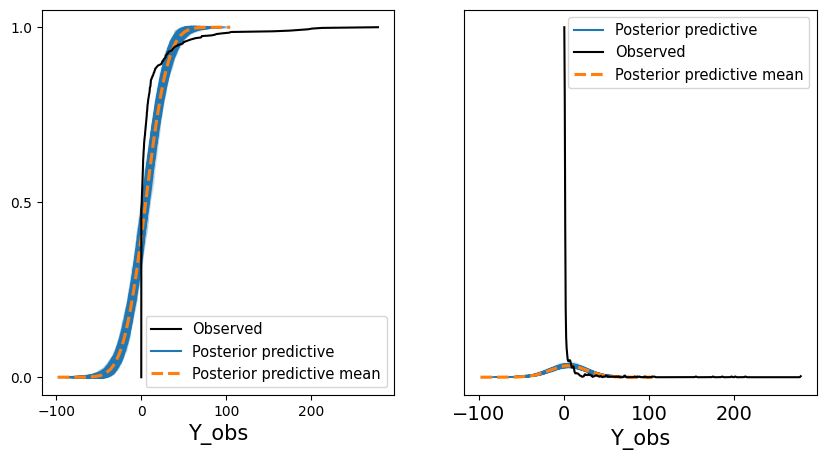

In [151]:
with model_ridge:
  trace_pos_ridge = pm.sample_posterior_predictive(trace_ridge)

analise_posteriori(trace_pos_ridge)

In [152]:
with pm.Model(coords=coords) as model_lasso:
  alpha = pm.Laplace('alpha', 0, 1)
  betas = pm.Laplace('betas', 0, 1, dims='features')
  epsilon = pm.HalfNormal('epsilon', 1)

  mu = alpha + tt.dot(X_f, betas)

  likelihood = pm.Normal('Y_obs', mu, epsilon, observed=y)
  lasso_trace_prior = pm.sample_prior_predictive()
  trace_lasso = pm.sample()

Output()

Output()

(<Figure size 1000x1000 with 6 Axes>,
 array([[<Axes: xlabel='Betas', ylabel='Contagem'>,
         <Axes: xlabel='Y_obs', ylabel='Contagem'>],
        [<Axes: title={'center': 'Predict a Priori'}, xlabel='Observado', ylabel='Predicted'>,
         <Axes: >],
        [<Axes: xlabel='Y_obs'>, <Axes: xlabel='Y_obs'>]], dtype=object))

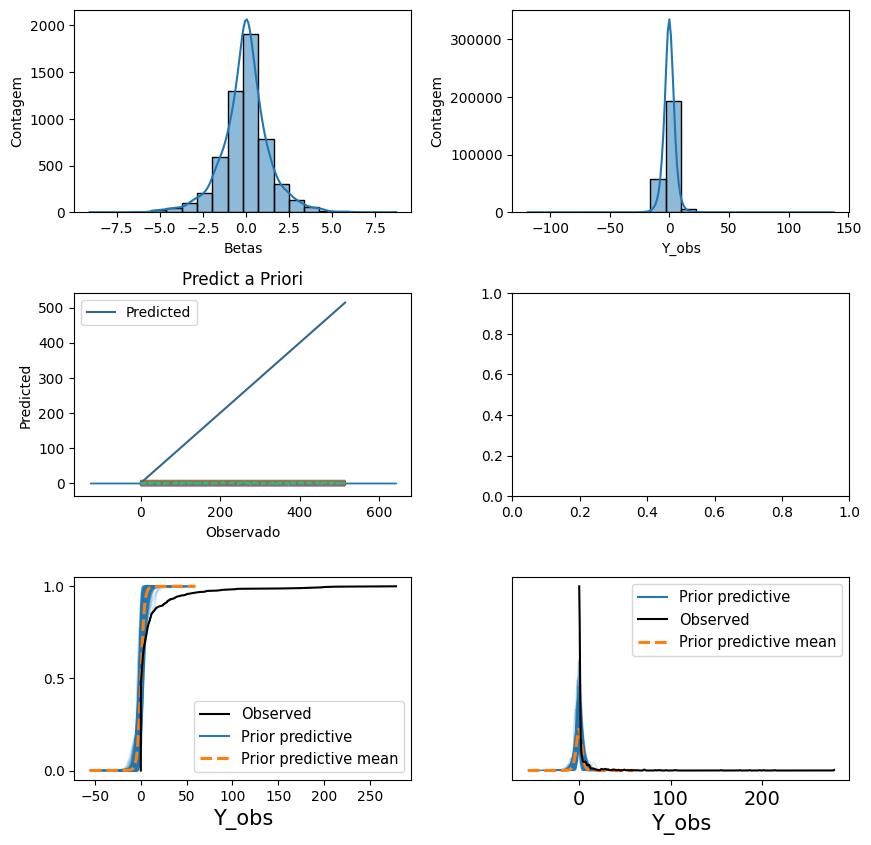

In [153]:
analise_priori(lasso_trace_prior)

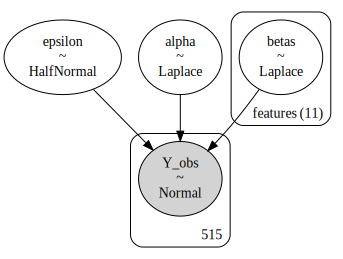

In [154]:
pm.model_to_graphviz(model_lasso)

In [155]:
pm.summary(trace_lasso)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,8.557,0.881,7.055,10.293,0.018,0.013,2303.0,1427.0,1.00
betas[month],0.940,0.982,-0.696,2.920,0.026,0.021,1664.0,1186.0,1.00
betas[day],-0.324,0.651,-1.563,0.834,0.015,0.015,2052.0,1310.0,1.00
betas[FFMC],0.189,0.744,-1.191,1.645,0.017,0.018,2075.0,1293.0,1.00
betas[DMC],0.922,0.919,-0.539,2.847,0.025,0.024,1572.0,964.0,1.00
betas[DC],-0.271,0.967,-2.105,1.493,0.029,0.028,1220.0,918.0,1.01
betas[ISI],-1.103,0.897,-2.762,0.446,0.022,0.018,1858.0,1388.0,1.00
betas[temp],0.918,0.951,-0.646,2.758,0.024,0.020,1655.0,1336.0,1.00
betas[RH],-0.414,0.785,-1.876,1.052,0.020,0.017,1636.0,1483.0,1.00
betas[wind],0.333,0.710,-0.894,1.803,0.015,0.018,2321.0,1393.0,1.00


Output()

(<Figure size 1000x500 with 2 Axes>,
 array([<Axes: xlabel='Y_obs'>, <Axes: xlabel='Y_obs'>], dtype=object))

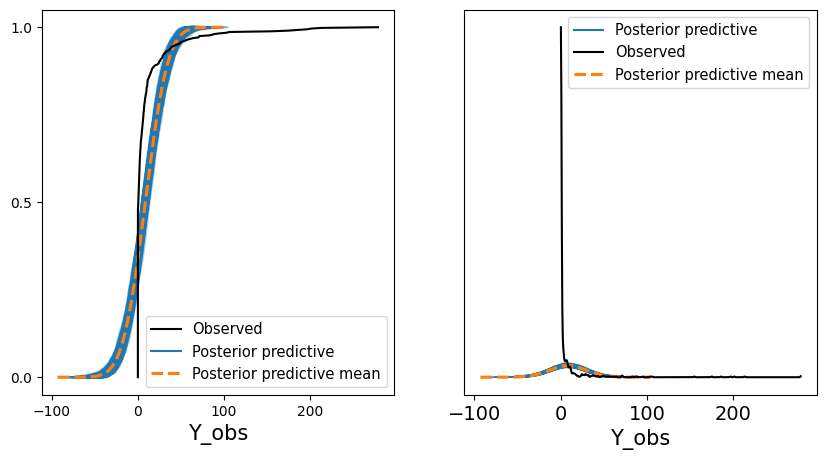

In [156]:
with model_lasso:
  trace_pos_lasso = pm.sample_posterior_predictive(trace_lasso)

analise_posteriori(trace_pos_lasso)

In [157]:
clusters = X_f['cluster'].values.astype(int) # convert the pandas Series to a numpy array of integers

with pm.Model(coords=coords) as model_hierarc:
  alpha = pm.Normal('alpha', mu=0, sigma=10, shape=5)
  betas = pm.Normal('betas', dims='features', mu=0, sigma=10)
  sigma = pm.HalfNormal('sigma', sigma=10)

  mu = alpha[clusters] + tt.dot(X_f, betas)

  Y_obs = pm.Normal('Y_obs', mu, sigma, observed=y)
  hierarc_trace_prior = pm.sample_prior_predictive()
  trace_hierarc = pm.sample()

Output()

Output()

(<Figure size 1000x1000 with 6 Axes>,
 array([[<Axes: xlabel='Betas', ylabel='Contagem'>,
         <Axes: xlabel='Y_obs', ylabel='Contagem'>],
        [<Axes: title={'center': 'Predict a Priori'}, xlabel='Observado', ylabel='Predicted'>,
         <Axes: >],
        [<Axes: xlabel='Y_obs'>, <Axes: xlabel='Y_obs'>]], dtype=object))

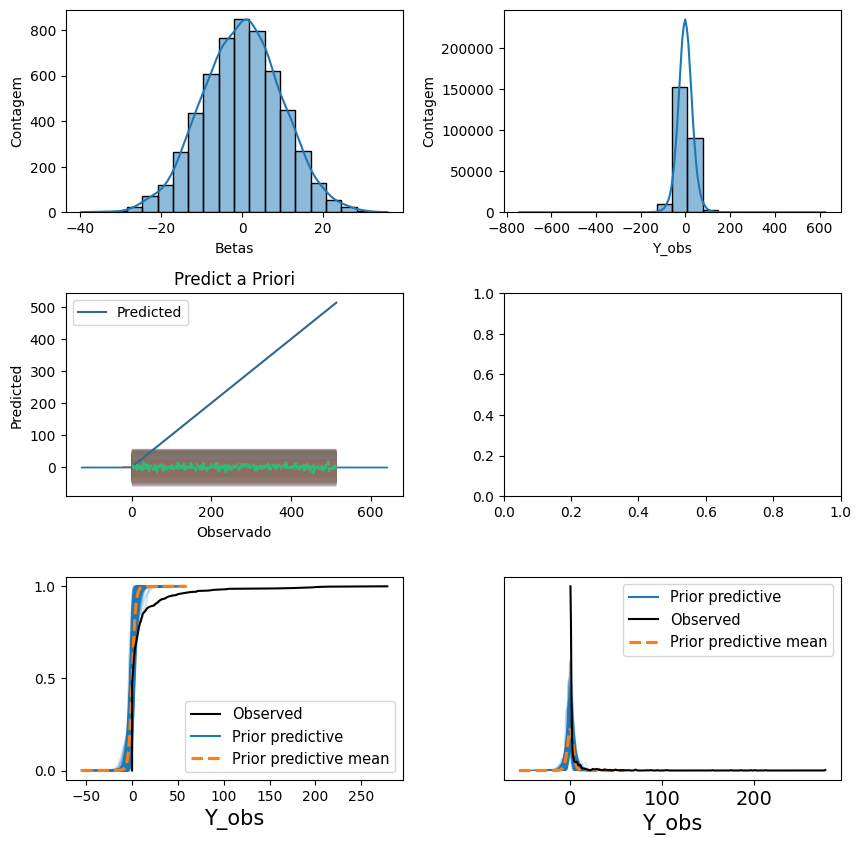

In [158]:
analise_priori(hierarc_trace_prior)

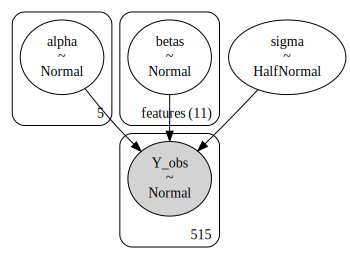

In [159]:
pm.model_to_graphviz(model_hierarc)

In [160]:
pm.summary(trace_hierarc)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],9.497,1.625,6.397,12.524,0.035,0.025,2118.0,1811.0,1.00
alpha[1],13.355,4.385,5.635,21.695,0.116,0.083,1444.0,1371.0,1.00
alpha[2],0.040,9.683,-19.511,16.910,0.185,0.221,2731.0,1352.0,1.00
alpha[3],0.053,10.616,-21.464,18.576,0.191,0.246,2981.0,1369.0,1.00
alpha[4],5.111,3.921,-2.006,12.669,0.102,0.073,1483.0,1406.0,1.00
betas[month],4.487,2.551,-0.176,9.356,0.059,0.045,1871.0,1367.0,1.00
betas[day],-0.486,1.162,-2.726,1.630,0.025,0.024,2242.0,1377.0,1.00
betas[FFMC],0.402,1.504,-2.244,3.284,0.031,0.028,2343.0,1584.0,1.01
betas[DMC],2.732,1.871,-0.640,6.472,0.040,0.029,2246.0,1544.0,1.00
betas[DC],-4.978,3.206,-10.945,1.110,0.078,0.068,1682.0,848.0,1.00


Output()

(<Figure size 1000x500 with 2 Axes>,
 array([<Axes: xlabel='Y_obs'>, <Axes: xlabel='Y_obs'>], dtype=object))

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


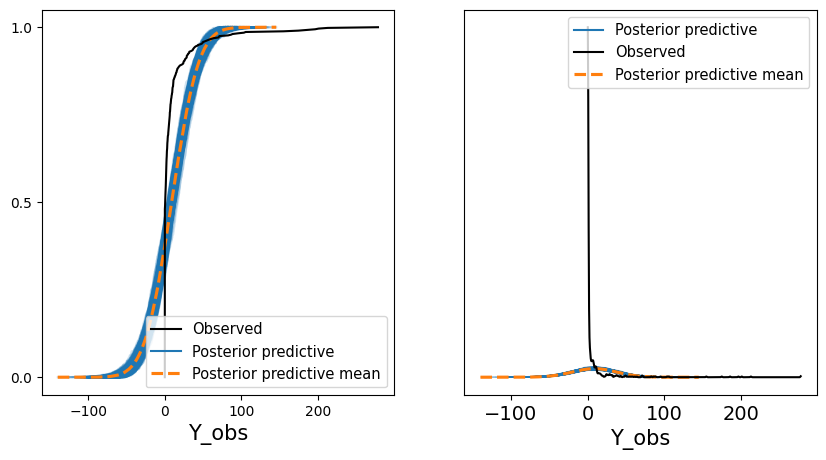

In [161]:
with model_hierarc:
  trace_pos_hierarc = pm.sample_posterior_predictive(trace_hierarc)

analise_posteriori(trace_pos_hierarc)

In [162]:
with pm.Model(coords=coords) as model_robust:
  alpha = pm.Normal('alpha', 0, 1)
  betas = pm.Normal('betas', 0, 1, dims='features')

  df = pm.Exponential('df', 1)
  mu = alpha + tt.dot(X_f, betas)

  likelihood = pm.StudentT('Y_obs', nu=df, mu=mu, observed=y)
  robust_trace_prior = pm.sample_prior_predictive()
  trace_robust = pm.sample()

Output()

Output()

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/usr/local/lib/python3.10/dist-packages/arviz/stats/density_utils.py:250: RuntimeWarning: divide by zero encountered in scalar power
  out = t - (2 * N * np.pi**0.5 * f) ** (-0.4)


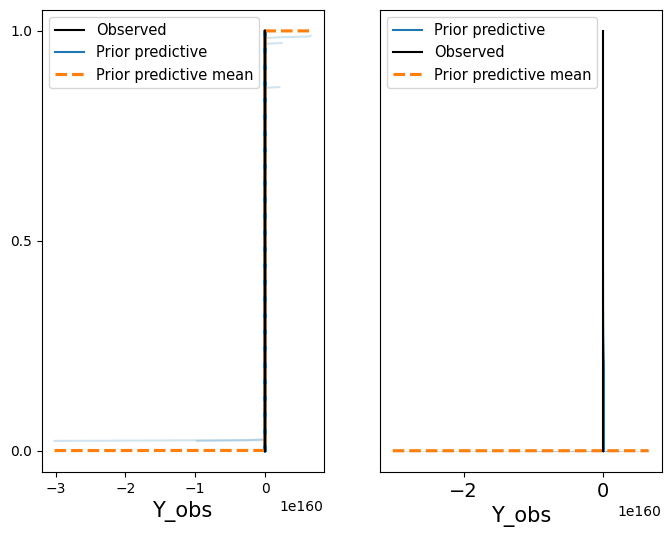

In [163]:
# Erro no histograma :(
#analise_priori(robust_trace_prior)

fig, axes = plt.subplots(1, 2, figsize=(8,6))

az.plot_ppc(robust_trace_prior, group='prior', kind='cumulative',ax=axes[0], observed=True);
az.plot_ppc(robust_trace_prior, group='prior',ax=axes[1], observed=True);

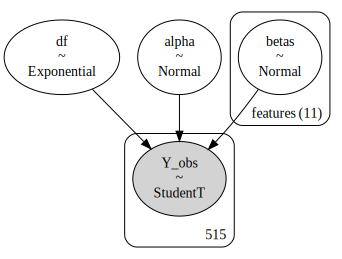

In [164]:
pm.model_to_graphviz(model_robust)

In [165]:
pm.summary(trace_robust)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.186,0.045,0.098,0.270,0.001,0.001,1423.0,1317.0,1.00
betas[month],0.012,0.125,-0.220,0.255,0.004,0.003,887.0,1009.0,1.00
betas[day],0.005,0.044,-0.077,0.089,0.001,0.001,2079.0,1399.0,1.00
betas[FFMC],0.013,0.049,-0.084,0.103,0.001,0.001,1489.0,1196.0,1.00
betas[DMC],-0.036,0.069,-0.175,0.084,0.002,0.002,1056.0,1102.0,1.00
betas[DC],0.016,0.140,-0.249,0.275,0.005,0.004,802.0,926.0,1.00
betas[ISI],0.003,0.052,-0.099,0.093,0.002,0.001,1128.0,1466.0,1.01
betas[temp],0.061,0.084,-0.090,0.217,0.002,0.002,1140.0,1215.0,1.00
betas[RH],0.023,0.065,-0.099,0.139,0.002,0.001,1195.0,1395.0,1.00
betas[wind],0.015,0.045,-0.071,0.098,0.001,0.001,1696.0,1505.0,1.00


Output()

(<Figure size 1000x500 with 2 Axes>,
 array([<Axes: xlabel='Y_obs'>, <Axes: xlabel='Y_obs'>], dtype=object))

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


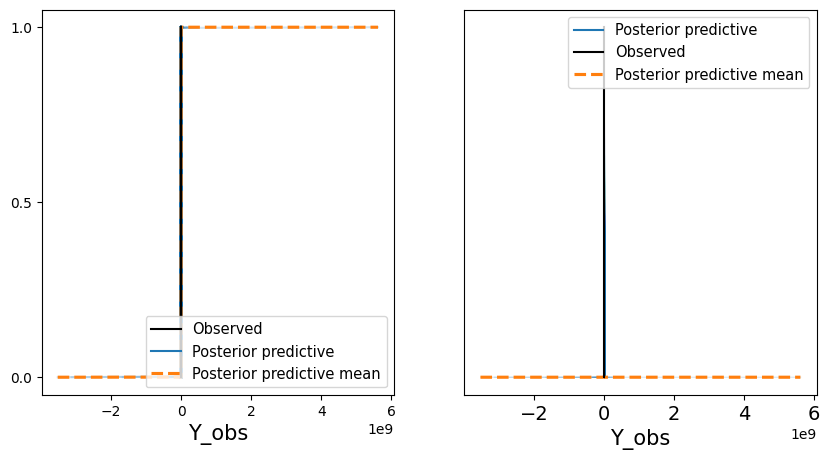

In [166]:
with model_robust:
  trace_pos_robust = pm.sample_posterior_predictive(trace_robust)

analise_posteriori(trace_pos_robust)

In [167]:
with model_ridge:
  pm.compute_log_likelihood(trace_ridge)
with model_hierarc:
  pm.compute_log_likelihood(trace_hierarc)
with model_lasso:
  pm.compute_log_likelihood(trace_lasso)
with model_robust:
  pm.compute_log_likelihood(trace_robust)

Output()

Output()

Output()

Output()

/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:792: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:792: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:792: UserWarning: Estimat

<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

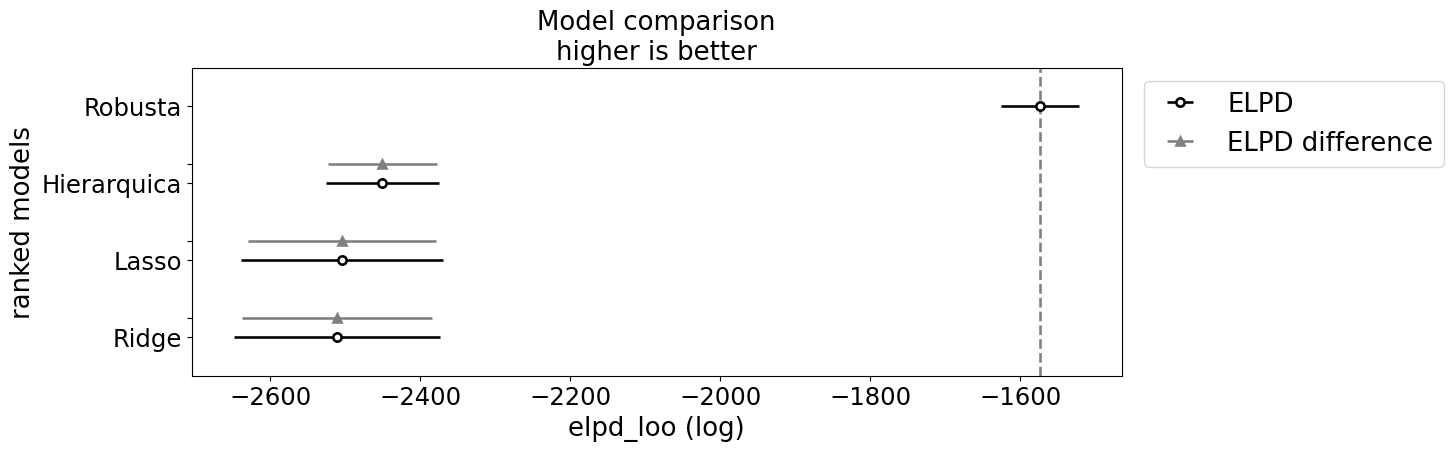

In [168]:
model_compare = az.compare(
    {
        "Ridge": trace_ridge,
        "Lasso": trace_lasso,
        "Hierarquica": trace_hierarc,
        "Robusta": trace_robust
    }, method='BB-pseudo-BMA'
)
az.plot_compare(model_compare, figsize=(12, 4), insample_dev=False)